In [108]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import ccobra.syllogistic as ccobra
import csv
import pandas as pd
from collections import defaultdict
import numpy as np

In [2]:
with open('ccobra-master/benchmarks/syllogistic/data/Ragni2016.csv') as f:
    file = csv.reader(f)
    raw_csv = [row for row in file]
    data = pd.DataFrame([row for row in raw_csv[1:]])

In [5]:
data.columns = raw_csv[0]
data

,id,sequence,task,choices,response,response_type,domain,gender,age
0,1,0,Some;models;managers/All;models;clerks,All;managers;clerks|All;clerks;managers|Some;m...,Some;managers;clerks,single-choice,syllogistic,female,56
1,1,1,No;divers;carpenters/All;linguists;carpenters,All;divers;linguists|All;linguists;divers|Some...,No;divers;linguists,single-choice,syllogistic,female,56
2,1,2,All;therapists;climbers/Some;skaters;therapists,All;climbers;skaters|All;skaters;climbers|Some...,Some;skaters;climbers,single-choice,syllogistic,female,56
3,1,3,All;bankers;golfers/All;golfers;teachers,All;bankers;teachers|All;teachers;bankers|Some...,All;bankers;teachers,single-choice,syllogistic,female,56
4,1,4,Some not;boxers;opticians/All;boxers;actuaries,All;opticians;actuaries|All;actuaries;optician...,Some not;actuaries;opticians,single-choice,syllogistic,female,56
...,...,...,...,...,...,...,...,...,...
8891,139,59,Some not;potters;sailors/All;potters;chemists,All;sailors;chemists|All;chemists;sailors|Some...,Some not;sailors;chemists,single-choice,syllogistic,female,23
8892,139,60,Some;brewers;porters/Some not;judges;porters,All;brewers;judges|All;judges;brewers|Some;bre...,No;judges;brewers,single-choice,syllogistic,female,23
8893,139,61,No;sculptors;bakers/Some not;bakers;gamblers,All;sculptors;gamblers|All;gamblers;sculptors|...,Some not;gamblers;sculptors,single-choice,syllogistic,female,23
8894,139,62,Some;climbers;therapists/All;skaters;therapists,All;climbers;skaters|All;skaters;climbers|Some...,NVC,single-choice,syllogistic,female,23


In [6]:
def find_syllogism(x):
    premise1, premise2 = [p.split(';') for p in x['task'].split('/')]
    response = x['response'].split(';')
    choices = [ccobra.encode_response(c.split(';'), (premise1,premise2)) for c in x['choices'].split('/')]
    
    task = ccobra.encode_task((premise1,premise2))
    conclusion = ccobra.encode_response(response, (premise1, premise2))
    
    correct = conclusion in choices
    
    return task, conclusion, correct

In [15]:
syllogism_correct = data.apply(find_syllogism, axis='columns', result_type='expand')
syllogism_correct.rename(columns={0:'task',1:'response_conclusion',2:'correct'})

,task,response_conclusion,correct
0,IA4,Iac,False
1,EA3,Eac,False
2,AI2,Ica,False
3,AA1,Aac,True
4,OA4,Oca,False
...,...,...,...
8891,OA4,Oac,False
8892,IO3,Eca,False
8893,EO1,Oca,False
8894,IA3,NVC,False


I am trying to visualize the responses in the data. At the moment this is raw counts, and there are not equal observations per syllogisms. I should therefore include proportions rather than counts, this will make all the bars the same height. This will also help with the logistic regression presumably.

In [161]:
response_counts = syllogism_correct.groupby([0, 1]).size()
response_counts_dict = defaultdict(lambda : 0, response_counts.to_dict())
syllogisms_dict = {name : index for index, name in enumerate(ccobra.SYLLOGISMS)}
response_dict = {name : index for index,name in enumerate(ccobra.RESPONSES)}
response_counts

0    1  
AA1  Aac    96
     Aca    13
     Eca     1
     Iac    11
     Ica     5
            ..
OO4  Iac    13
     Ica     9
     NVC    83
     Oac    14
     Oca    16
Length: 517, dtype: int64

In [162]:
response_count_mat = np.zeros((len(ccobra.SYLLOGISMS), len(ccobra.RESPONSES)))
for key,value in response_counts_dict.items():
    row = syllogisms_dict[key[0]]
    column = response_dict[key[1]]
    response_count_mat[row][column] = count = response_counts_dict[key]

In [163]:
response_proportions = (response_count_mat.T / response_count_mat.sum(axis=1)).T

<AxesSubplot:title={'center':'Stacked Bar Graph by dataframe'}, xlabel='syll'>

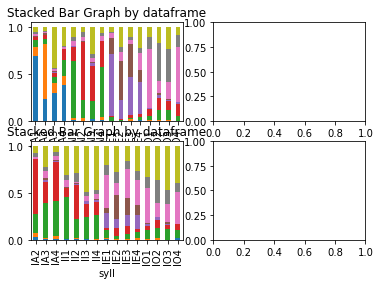

In [215]:
newdat = pd.DataFrame(response_proportions)
newdat.insert(0,'syll',ccobra.SYLLOGISMS)

fig, axes = plt.subplots(nrows=2, ncols=2)

newdat[0:16].plot(x='syll', kind='bar', stacked=True,
        title='Stacked Bar Graph by dataframe', ax=axes[0,0], legend=False)
newdat[17:32].plot(x='syll', kind='bar', stacked=True,
        title='Stacked Bar Graph by dataframe', ax=axes[1,0], legend=False)

In [208]:
pd.DataFrame(response_proportions)[0:16]

,0,1,2,3,4,5,6,7,8
0,0.690647,0.093525,0.079137,0.035971,0.000000,0.007194,0.021583,0.021583,0.050360
1,0.237410,0.582734,0.057554,0.043165,0.000000,0.014388,0.007194,0.014388,0.043165
2,0.302158,0.107914,0.064748,0.035971,0.014388,0.007194,0.021583,0.007194,0.438849
3,0.381295,0.100719,0.165468,0.115108,0.007194,0.000000,0.021583,0.007194,0.201439
4,0.014388,0.014388,0.611511,0.151079,0.007194,0.000000,0.050360,0.050360,0.100719
5,0.007194,0.028777,0.194245,0.611511,0.000000,0.007194,0.043165,0.057554,0.050360
6,0.021583,0.000000,0.194245,0.374101,0.028777,0.014388,0.043165,0.035971,0.287770
7,0.014388,0.028777,0.532374,0.273381,0.000000,0.000000,0.057554,0.028777,0.064748
8,0.000000,0.007194,0.035971,0.014388,0.654676,0.172662,0.050360,0.007194,0.057554
9,0.000000,0.007194,0.007194,0.007194,0.208633,0.410072,0.093525,0.050360,0.215827


[0.69064748 0.23741007]
[0.09352518 0.58273381]
[0.07913669 0.05755396]
[0.03597122 0.04316547]
[0. 0.]
[0.00719424 0.01438849]
[0.02158273 0.00719424]
[0.02158273 0.01438849]
[0.05035971 0.04316547]


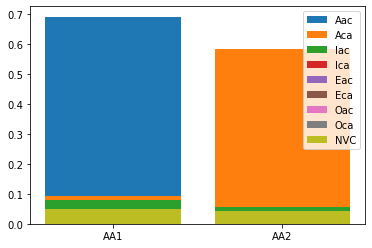

In [196]:
fig, ax = plt.subplots()

labels = ccobra.SYLLOGISMS[0:2]
for index, conclusion in enumerate(ccobra.RESPONSES):
    counts = response_proportions.T[index]
    ax.bar(labels, counts[0:2], label=conclusion)
    print(counts[0:2])
plt.legend()

<BarContainer object of 9 artists>

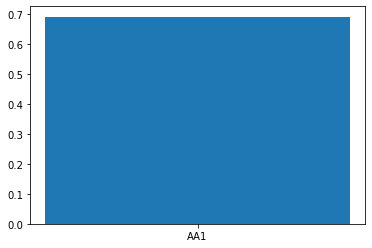

In [176]:
plt.bar('AA1', response_proportions[0])